<a href="https://colab.research.google.com/github/mikiya2014/My-projects/blob/main/Project_Yahoo_Description_Predict_Sector_Widget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yahoo_Description_Predict_Sector


# Overview of the Notebook:
In this notebook, selected company description scraped from Yahoo Finance will be used to predict sectors of those companies. Bidirectional LSTM model is the best model.

# Overview of the Dataset:
There are 565 tickers used for scraping and are stored in Excel file which has symbols and sectors. 

### Import Packages

In [ ]:
import urllib
from bs4 import BeautifulSoup
from pandas import read_excel
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tensorflow.keras.callbacks import EarlyStopping
#https://drive.google.com/file/d/1X-dlVD3dwoU38gR3U2B5E-LDLMyBfwAd/view?usp=sharing

## Student To-do List:
1.   Read file that contains tickers and sectors.
2.   Web Scraping company descriptions from Yahoo Finance company profile and save to dataframe.
3.   Prepare for the model.
4.   Fit models and evaluate the models.
5.   Add pre-trained embeddings (Glove6B.100d).

### Read file that contains tickers and sectors.

In [ ]:
url = "https://drive.google.com/uc?export=download&id=1X-dlVD3dwoU38gR3U2B5E-LDLMyBfwAd" 
dataframe = pd.read_excel(url, header=0)
symbol_list = pd.DataFrame(dataframe)
symbol_list

,Symbol,Sector
0,APA,Energy
1,BKR,Energy
2,COG,Energy
3,COP,Energy
4,CVX,Energy
...,...,...
561,AVNW,Info Technology
562,TESS,Info Technology
563,MINDP,Info Technology
564,AVGOP,Info Technology


In [ ]:
symbol_list=shuffle(symbol_list)
symbol_list=symbol_list.dropna()

In [ ]:
symbol_list

,Symbol,Sector
97,ZBRA,Info Technology
503,NTGR,Info Technology
449,PRO,Info Technology
89,TEL,Info Technology
494,CLS,Info Technology
...,...,...
30,ADBE,Info Technology
467,INFN,Info Technology
95,XLNX,Info Technology
208,KRP,Energy


In [ ]:
# symbol_list.set_index('Symbol',inplace=True)
# symbol_list

### Web Scraping company descriptions from Yahoo Finance company profile and save to dataframe.

In [ ]:
tem=[]
for index, row in symbol_list.iterrows(): 
  symbol=row['Symbol'].strip()
  url = "https://finance.yahoo.com/quote/"+symbol+"/profile?p="+symbol

  html = urllib.request.urlopen(url).read()
  soup = BeautifulSoup(html)
  # kill all script and style elements
  for script in soup(["script", "style"]):
      script.extract()    # rip it out
  # get text
  text = soup.get_text()
  # break into lines and remove leading and trailing space on each
  lines = (line.strip() for line in text.splitlines())
  # break multi-headlines into a line each
  chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
  # drop blank lines
  text = '\n'.join(chunk for chunk in chunks if chunk)

  words_list = text.split() 
#capture words from "Description"
  for count, word in enumerate(words_list):
    if 'Description' in word:
      start_des=count+1
  
  new_words_list=words_list[start_des:]
  new_text=' '.join(new_words_list)
  tem.append(new_text)


In [ ]:
#append "Description" to the data
symbol_list['Description']=tem
symbol_list

,Symbol,Sector,Description
97,ZBRA,Info Technology,"Technologies Corporation, together with its su..."
503,NTGR,Info Technology,"Inc. designs, develops, and markets networking..."
449,PRO,Info Technology,"Holdings, Inc. offers artificial intelligence ..."
89,TEL,Info Technology,"Connectivity Ltd., together with its subsidiar..."
494,CLS,Info Technology,"Inc. provides design, manufacturing, hardware ..."
...,...,...,...
30,ADBE,Info Technology,Inc. operates as a diversified software compan...
467,INFN,Info Technology,Corporation provides optical transport network...
95,XLNX,Info Technology,Inc. designs and develops programmable devices...
208,KRP,Energy,"Royalty Partners, LP acquires and owns mineral..."


In [ ]:
#use this code within the previous for loop to get the sectors
# sec=[]
# for count, word in enumerate(words_list):
#   if 'Sector' in word:
#     sec.append(words_list[count+1])
# sec

### Prepare for the model.

#### Create dummy variables of the target sectors.


In [ ]:
dummy=[]
for index, row in symbol_list.iterrows(): 
  if row['Sector']=='Info Technology':
    dummy.append(0)
  elif row['Sector']=='Energy':
    dummy.append(1)
symbol_list['Dummy']=dummy

In [ ]:
symbol_list.head()

,Symbol,Sector,Description,Dummy
97,ZBRA,Info Technology,"Technologies Corporation, together with its su...",0
503,NTGR,Info Technology,"Inc. designs, develops, and markets networking...",0
449,PRO,Info Technology,"Holdings, Inc. offers artificial intelligence ...",0
89,TEL,Info Technology,"Connectivity Ltd., together with its subsidiar...",0
494,CLS,Info Technology,"Inc. provides design, manufacturing, hardware ...",0


In [ ]:

labels = symbol_list['Dummy'].values
texts = symbol_list['Description'].values


In [ ]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,

#### Tokenize the texts, convert to sequences and pad the sequences.

In [ ]:
# Tokenize, pad and prepare training and validation data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np 

# DW is trying 500 instead of 10K words to see what the accuracy would be
def data_preprocess(maxlen,training_samples,validation_samples,max_words):
  tokenizer = Tokenizer(num_words=max_words)

  # fit_on_texts means it learns the indices of the words
  tokenizer.fit_on_texts(texts)

  # the sequences are comprised of those indices
  sequences = tokenizer.texts_to_sequences(texts)

  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  # in case of low word counts, we need to pad sequences
  # so that they are uniform length
  data = pad_sequences(sequences, maxlen=maxlen)
  return data,maxlen,training_samples,validation_samples,max_words,word_index
# our labels, which were previously stored as a list [],
# are now converted to a numpy array for modeling
labels = np.asarray(labels)
# print('Shape of data tensor:', data.shape)
# print('Shape of label tensor:', labels.shape)

In [ ]:
data_=interactive(data_preprocess,maxlen=(20,500,50),training_samples=(100,565,1),validation_samples=(100,565,1),max_words=(50,10000,50))
display(data_)

interactive(children=(IntSlider(value=220, description='maxlen', max=500, min=20, step=50), IntSlider(value=33…

#### Partition the data.

In [ ]:
data=data_.result[0]
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

training_samples=data_.result[2]
validation_samples=data_.result[3]
x_train = data[:training_samples] # from 0 to training samples
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] # from the end of training to the end of validation
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
print(x_train.shape)
print(x_val.shape)

(332, 220)
(227, 220)


### Fit models and evaluate the models.

In [ ]:
maxlen=data_.result[1]
max_words=data_.result[4]
word_index=data_.result[5]

#### Build simple RNN model

In [ ]:
# build simple RNN model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(SimpleRNN(128,activation='relu',return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 220, 100)          500000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 533,473
Trainable params: 533,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 1s 109ms/step - loss: 0.7747 - acc: 0.6566 - val_loss: 0.6302 - val_acc: 0.6872
Epoch 2/10
11/11 [==============================] - 1s 91ms/step - loss: 0.6067 - acc: 0.7199 - val_loss: 0.6333 - v

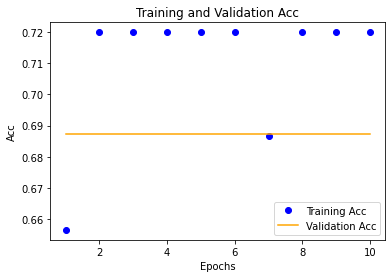

In [ ]:
#@title Let's see the training and validation accuracy by epoch { run: "auto", display-mode: "form" }
import matplotlib.pyplot as plt
history_dict = history.history
value = 'acc' #@param ['loss','acc']
loss_values = history_dict[value] # you can change this
val_loss_values = history_dict['val_'+ value] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training {}'.format(value.title()))
plt.plot(epochs, val_loss_values, 'orange', label='Validation {}'.format(value.title()))
plt.title('Training and Validation {}'.format(value.title()))
plt.xlabel('Epochs')
plt.ylabel('{}'.format(value.title()))
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


              precision    recall  f1-score   support

           0       0.64      0.62      0.63       149
           1       0.31      0.32      0.31        78

    accuracy                           0.52       227
   macro avg       0.47      0.47      0.47       227
weighted avg       0.52      0.52      0.52       227

Confusion Matrix:



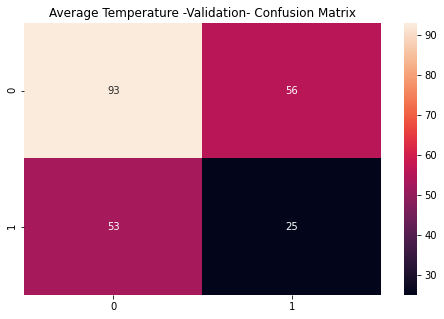

In [ ]:
#@title Make Predictions-Choosing cut-off point { run: "auto", display-mode: "form" }
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    from sklearn.metrics import roc_curve
    import pandas as pd
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
X_data = {'train': x_train,'validation': x_val}
data = 'validation' #@param ['train','validation']
preds = model.predict(X_data[data])
actual = {'train': y_train,'validation':y_val} 

threshold = Find_Optimal_Cutoff(actual[data],preds)
# Put prediction to the dataframe applying threshold
threshold_dict = {"optimal cutoff": threshold[0],"mean predicted probability": np.mean(preds)}
method = 'optimal cutoff' #@param ['optimal cutoff','mean predicted probability']
predicted = []
for i in preds:
  if i >= threshold_dict[method]:
    predicted.append(1)
  else:
    predicted.append(0)
print(classification_report(actual[data],predicted))
matrix = confusion_matrix(actual[data],predicted)
matrix = pd.DataFrame(matrix)
print('Confusion Matrix:\n')
plt.subplots(figsize=(8,5))
plt.title('Average Temperature -{}- Confusion Matrix'.format(data.title()))
sns.heatmap(matrix,annot=True,fmt='d')

#### Build a Bidirectional LSTM model with 1DConv and 1DMaxpooling on the embeddings.

In [ ]:

model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, activation='relu',return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 220, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 220, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 674,753
Trainable params: 674,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 6s 569ms/step - loss: 0.6646 - acc: 0.6355 - val_loss: 0.6298 

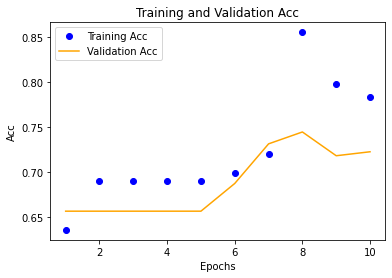

In [ ]:
#@title Let's see the training and validation accuracy by epoch { run: "auto", display-mode: "form" }
import matplotlib.pyplot as plt
history_dict = history.history
value = 'acc' #@param ['loss','acc']
loss_values = history_dict[value] # you can change this
val_loss_values = history_dict['val_'+ value] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training {}'.format(value.title()))
plt.plot(epochs, val_loss_values, 'orange', label='Validation {}'.format(value.title()))
plt.title('Training and Validation {}'.format(value.title()))
plt.xlabel('Epochs')
plt.ylabel('{}'.format(value.title()))
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       149
           1       0.96      0.94      0.95        78

    accuracy                           0.96       227
   macro avg       0.96      0.96      0.96       227
weighted avg       0.96      0.96      0.96       227

Confusion Matrix:



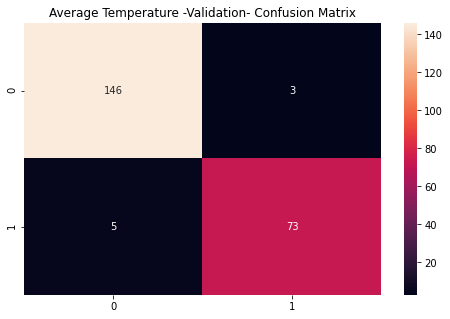

In [ ]:
#@title Make Predictions-Choosing cut-off point { run: "auto", display-mode: "form" }
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    from sklearn.metrics import roc_curve
    import pandas as pd
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
X_data = {'train': x_train,'validation': x_val}
data = 'validation' #@param ['train','validation']
preds = model.predict(X_data[data])
actual = {'train': y_train,'validation':y_val} 

threshold = Find_Optimal_Cutoff(actual[data],preds)
# Put prediction to the dataframe applying threshold
threshold_dict = {"optimal cutoff": threshold[0],"mean predicted probability": np.mean(preds)}
method = 'optimal cutoff' #@param ['optimal cutoff','mean predicted probability']
predicted = []
for i in preds:
  if i >= threshold_dict[method]:
    predicted.append(1)
  else:
    predicted.append(0)
print(classification_report(actual[data],predicted))
matrix = confusion_matrix(actual[data],predicted)
matrix = pd.DataFrame(matrix)
print('Confusion Matrix:\n')
plt.subplots(figsize=(8,5))
plt.title('Average Temperature -{}- Confusion Matrix'.format(data.title()))
sns.heatmap(matrix,annot=True,fmt='d')

#### Build LSTM model.

In [ ]:
# build LSTM model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 220, 100)          500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 544,353
Trainable params: 544,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 4s 363ms/step - loss: 0.6596 - acc: 0.6717 - val_loss: 0.6235 - val_acc: 0.6872
Epoch 2/10
11/11 [==============================] - 4s 330ms/step - loss: 0.6015 - acc: 0.7199 - val_loss: 0.6150 

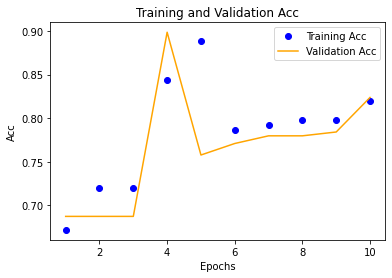

In [ ]:
#@title Let's see the training and validation accuracy by epoch { run: "auto", display-mode: "form" }
import matplotlib.pyplot as plt
history_dict = history.history
value = 'acc' #@param ['loss','acc']
loss_values = history_dict[value] # you can change this
val_loss_values = history_dict['val_'+ value] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training {}'.format(value.title()))
plt.plot(epochs, val_loss_values, 'orange', label='Validation {}'.format(value.title()))
plt.title('Training and Validation {}'.format(value.title()))
plt.xlabel('Epochs')
plt.ylabel('{}'.format(value.title()))
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       149
           1       0.66      0.78      0.72        78

    accuracy                           0.79       227
   macro avg       0.77      0.79      0.77       227
weighted avg       0.80      0.79      0.79       227

Confusion Matrix:



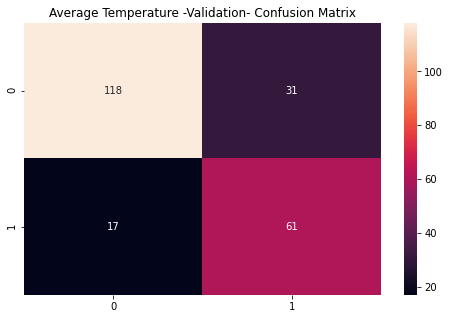

In [ ]:
#@title Make Predictions-Choosing cut-off point { run: "auto", display-mode: "form" }
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    from sklearn.metrics import roc_curve
    import pandas as pd
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
X_data = {'train': x_train,'validation': x_val}
data = 'validation' #@param ['train','validation']
preds = model.predict(X_data[data])
actual = {'train': y_train,'validation':y_val} 

threshold = Find_Optimal_Cutoff(actual[data],preds)
# Put prediction to the dataframe applying threshold
threshold_dict = {"optimal cutoff": threshold[0],"mean predicted probability": np.mean(preds)}
method = 'optimal cutoff' #@param ['optimal cutoff','mean predicted probability']
predicted = []
for i in preds:
  if i >= threshold_dict[method]:
    predicted.append(1)
  else:
    predicted.append(0)
print(classification_report(actual[data],predicted))
matrix = confusion_matrix(actual[data],predicted)
matrix = pd.DataFrame(matrix)
print('Confusion Matrix:\n')
plt.subplots(figsize=(8,5))
plt.title('Average Temperature -{}- Confusion Matrix'.format(data.title()))
sns.heatmap(matrix,annot=True,fmt='d')

### Add pre-trained embeddings (Glove6B.100d)

#### Mount drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Read in glove100d data.

In [ ]:
import os
# Use your directory
glove_dir = '/content/drive/My Drive/Spring 2020 Materials/Week 4/Module 4/Script and Data/Embedding examples/GLoVE Data'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


#### Define embedding vector.

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Build LSTM model.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 220, 100)          500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 544,353
Trainable params: 544,353
Non-trainable params: 0
_________________________________________________________________


#### Add pre-trained embedding layer.

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

#### Train the model.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
11/11 [==============================] - 4s 319ms/step - loss: 0.6352 - acc: 0.6596 - val_loss: 0.6416 - val_acc: 0.6564
Epoch 2/10
11/11 [==============================] - 3s 291ms/step - loss: 0.6085 - acc: 0.7078 - val_loss: 0.6326 - val_acc: 0.6872
Epoch 3/10
11/11 [==============================] - 3s 291ms/step - loss: 0.6089 - acc: 0.7199 - val_loss: 0.6432 - val_acc: 0.6872
Epoch 4/10
11/11 [==============================] - 3s 286ms/step - loss: 0.6116 - acc: 0.7199 - val_loss: 0.6413 - val_acc: 0.6872
Epoch 5/10
11/11 [==============================] - 3s 287ms/step - loss: 0.6047 - acc: 0.7199 - val_loss: 0.6262 - val_acc: 0.6872
Epoch 6/10
11/11 [==============================] - 3s 284ms/step - loss: 0.6022 - acc: 0.7199 - val_loss: 0.6214 - val_acc: 0.6872
Epoch 7/10
11/11 [==============================] - 3s 284ms/step - loss: 0.5874 - acc: 0.7199 - val_loss: 0.6343 - val_acc: 0.6872
Epoch 8/10
11/11 [==============================] - 3s 285ms/step - loss: 0.

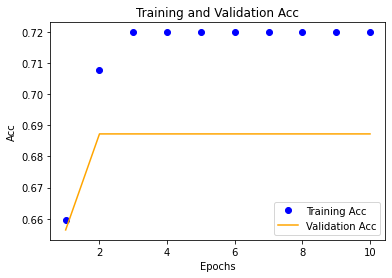

In [ ]:
#@title Let's see the training and validation accuracy by epoch { run: "auto", display-mode: "form" }
import matplotlib.pyplot as plt
history_dict = history.history
value = 'acc' #@param ['loss','acc']
loss_values = history_dict[value] # you can change this
val_loss_values = history_dict['val_'+ value] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training {}'.format(value.title()))
plt.plot(epochs, val_loss_values, 'orange', label='Validation {}'.format(value.title()))
plt.title('Training and Validation {}'.format(value.title()))
plt.xlabel('Epochs')
plt.ylabel('{}'.format(value.title()))
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.44      0.51       149
           1       0.30      0.45      0.36        78

    accuracy                           0.44       227
   macro avg       0.45      0.45      0.43       227
weighted avg       0.50      0.44      0.46       227

Confusion Matrix:



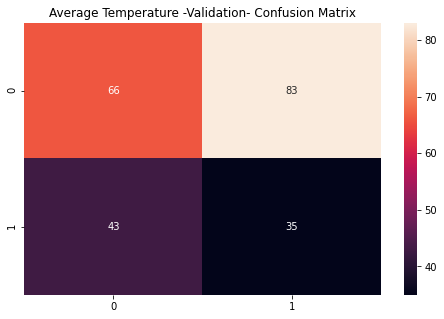

In [ ]:
#@title Make Predictions-Choosing cut-off point { run: "auto", display-mode: "form" }
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    from sklearn.metrics import roc_curve
    import pandas as pd
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
X_data = {'train': x_train,'validation': x_val}
data = 'validation' #@param ['train','validation']
preds = model.predict(X_data[data])
actual = {'train': y_train,'validation':y_val} 

threshold = Find_Optimal_Cutoff(actual[data],preds)
# Put prediction to the dataframe applying threshold
threshold_dict = {"optimal cutoff": threshold[0],"mean predicted probability": np.mean(preds)}
method = 'optimal cutoff' #@param ['optimal cutoff','mean predicted probability']
predicted = []
for i in preds:
  if i >= threshold_dict[method]:
    predicted.append(1)
  else:
    predicted.append(0)
print(classification_report(actual[data],predicted))
matrix = confusion_matrix(actual[data],predicted)
matrix = pd.DataFrame(matrix)
print('Confusion Matrix:\n')
plt.subplots(figsize=(8,5))
plt.title('Average Temperature -{}- Confusion Matrix'.format(data.title()))
sns.heatmap(matrix,annot=True,fmt='d')